In [1]:
import os;
import sys;
import random;
import math
import json
import imutils;

import numpy as np;
import cv2;
import matplotlib.pyplot as plt;



import tensorflow as tf
from tensorflow import keras;

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import roc_curve, auc

from keras import backend as K

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
glandModel = tf.keras.models.load_model("gland_unet.hdf5",compile=False);

In [3]:
trainData= "./public_data/trainData";
trainDataList = os.listdir(trainData);

#testData = "./public_data/testData";
#testDataList = os.listdir(testData);

In [4]:
#read all training data ,   and save to an object.


images=dict()
for x in trainDataList:
    
    training_img =trainData+"/"+x+"/crop.png";
    mask_coor = trainData+"/"+x+"/gland_anno.json";
    
    training_img = cv2.imread(training_img);
    
    anno=[];
    if not os.path.exists(mask_coor):
        anno=[];
    else:
        mask_coor= json.load(open(mask_coor) );
        for i in mask_coor:
            coor=mask_coor[i]["coors"];
            coor = [np.asarray(x) for x in coor];
            anno.append(np.asarray(coor));
            
    anno = np.asarray(anno);
    mask = np.zeros((training_img.shape[0],training_img.shape[1]))
    for a in anno:
        mask=cv2.fillPoly(mask, np.asarray([a]), 1);
    
    images[x]={"image":training_img,"mask":mask}

In [5]:
inputshape=(512,512);
step=(450,450);

In [6]:
#create a list to save image ids, id include the location of each tile


image_ids=[];
for annf in trainDataList:
    training_img = images[annf]["image"];
    
    w = training_img.shape[1]
    h = training_img.shape[0]
    x_count = math.ceil((w-int(inputshape[0]) )/float(step[0]))+1
    y_count = math.ceil((h-int(inputshape[1]) )/float(step[1]))+1;
    x_array=[];
    y_array=[];
    for i in range(x_count):
        xindex= int(step[0])*i;

        if xindex+int(inputshape[0]) > w:
            xindex = w-int(inputshape[0]);

        x_array.append(xindex)

    for i in range(y_count):
        yindex= int(step[1])*i;
        if yindex+int(inputshape[1]) > h:
            yindex = h-int(inputshape[1]);

        y_array.append(yindex)
    
    for i in x_array:
        for j in y_array:
            
            image_ids.append(annf+"___"+str(i)+"_"+str(j));
            
            
random.shuffle(image_ids)


In [7]:
#Data generate random augmentation and transformed tiles and mask  for each id. 
class DataGen(keras.utils.Sequence):
    def __init__(self,ids,batch_size=10,image_size=(512,512),mask="mask",aug=False):
        self.ids=ids;
        self.aug = aug;
        self.batch_size =batch_size;
        self.image_size = image_size;
        self.mask = mask;
        
    def __load__(self,id_name):
        
        id_name_arr=id_name.split("___");
        xywh=id_name_arr[1].split("_");
        
        image_size=self.image_size;
        
        idx = int(xywh[0])
        idy = int(xywh[1])
        idw = int(image_size[0])
        idh = int(image_size[1])
        
        
        if self.aug==True:
            randomWH=(random.choice(range( int(-image_size[0]/6),int(image_size[0]/6),  int( image_size[0]/60 )     )),random.choice(range(int(-image_size[0]/6),int(image_size[0]/6),     int( image_size[0]/60 )    )))
        else:
            randomWH=(0,0)
        
        image = images[id_name_arr[0]]["image"];
        image = image[idy: (idy+idh+randomWH[1]), idx :(idx+idw+randomWH[0])];
        
        image =np.asarray(image);
        
        mask = images[id_name_arr[0]][self.mask];
            
        mask = mask[idy: (idy+idh+randomWH[1]), idx :(idx+idw+randomWH[0])];
        mask= np.asarray(mask);
            
        image = cv2.resize(image,image_size);
        mask = cv2.resize(mask,image_size);
        
        
        thresh = 0.5;
        mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]
        
        
        if self.aug==True:
            n = random.choice([0,1]);
            if n==0:
                image =  cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3);
                
            n = random.choice([0,1,3,5]);
            if n !=0:
                image = cv2.GaussianBlur(image,(n,n),cv2.BORDER_DEFAULT);
                
            n = random.choice([1,1.25,1.5,1.75,2]);
            shape = image.shape
            
            shapeY = int(shape[0]/n)
            shapeX = int(shape[1]/n)
            image = cv2.resize(image,(shapeX,shapeY))
            
        else:
            image =  cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)    
        
        image = cv2.resize(image,image_size);
        mask=cv2.resize(mask,image_size);
    
        n = random.choice([0,90,180,270]);
        if n !=0 and self.aug==True:
            
            image = imutils.rotate(image, n);
            mask = imutils.rotate(mask, n);
            
        mask = np.expand_dims(mask,axis=-1);
        mask2 = np.zeros_like(mask);
        mask =np.maximum(mask2,mask);
        
        image =image/255.0;
        mask = mask/255.0;
        
        return image, mask;
    
    def __getitem__(self,index):
        if (index+1)*self.batch_size >len(self.ids):
            self.bach_size=len(self.ids)-index*self.batch_size;
        
        files_batch = self.ids[index*self.batch_size:(index+1)*self.batch_size]

        image=[];
        mask=[];
        
        for id_name in files_batch:
            _img,_mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask);
        
        image =np.array(image)
        mask =np.array(mask);
        
        return image, mask;
    
    def on_epoch_end(self):
        pass;
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));

In [8]:
#check a data. make sure the function working
test_ids=image_ids[0:10]
test_data = DataGen(test_ids,aug=False)

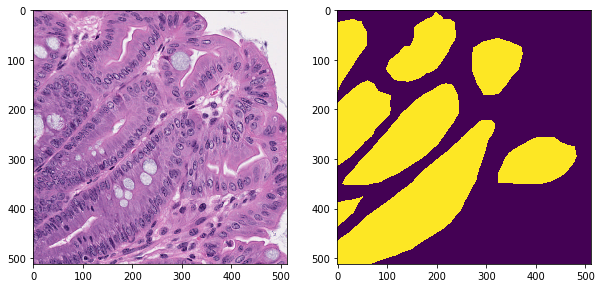

In [9]:
x,y = test_data.__getitem__(1)


r=random.randint(0,len(x)-1);

fig = plt.figure(figsize=(10,10));
ax = fig.add_subplot(1,2,1)
ax.imshow(x[r])
ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y[r],inputshape))




In [10]:
#f1 score for measure the performance of model


def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
glandModel.compile(optimizer = "adam",loss="binary_crossentropy",metrics=['acc',f1_m,precision_m, recall_m]);
glandModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
checkpoint = ModelCheckpoint('gland_check.hdf5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')


In [13]:
#training   each loop will random sperate the train data  and valid data.
batch_size=30

for i in range(1):
    valids= random.sample(image_ids,int(len(image_ids)/20));
    traids= [x for x in image_ids if x not in valids];
    
    train_data = DataGen(traids,batch_size=batch_size,image_size = inputshape,aug=True)
    valid_data = DataGen(valids,batch_size=batch_size,image_size = inputshape)
    
    train_steps= len(traids)//batch_size;
    valid_steps= len(valids)//batch_size;
    
    
    epochs=3
    result = glandModel.fit_generator(train_data, validation_data=valid_data, 
                                 steps_per_epoch=train_steps, 
                                 validation_steps=valid_steps, 
                                epochs=epochs,callbacks=[checkpoint])

Epoch 1/3
68/69 [============================>.] - ETA: 31s - loss: 0.0543 - acc: 0.9781 - f1_m: 0.7724 - precision_m: 0.8062 - recall_m: 0.7626 
Epoch 00001: val_loss improved from inf to 0.05318, saving model to gland_check.hdf5
69/69 [==============================] - 2192s 32s/step - loss: 0.0545 - acc: 0.9780 - f1_m: 0.7733 - precision_m: 0.8055 - recall_m: 0.7649 - val_loss: 0.0532 - val_acc: 0.9786 - val_f1_m: 0.7843 - val_precision_m: 0.7404 - val_recall_m: 0.8446
Epoch 2/3
68/69 [============================>.] - ETA: 31s - loss: 0.0499 - acc: 0.9798 - f1_m: 0.7957 - precision_m: 0.8219 - recall_m: 0.7863 
Epoch 00002: val_loss improved from 0.05318 to 0.05267, saving model to gland_check.hdf5
69/69 [==============================] - 2181s 32s/step - loss: 0.0498 - acc: 0.9798 - f1_m: 0.7966 - precision_m: 0.8223 - recall_m: 0.7873 - val_loss: 0.0527 - val_acc: 0.9782 - val_f1_m: 0.7746 - val_precision_m: 0.7663 - val_recall_m: 0.7937
Epoch 3/3
68/69 [=========================